# Market Impact Models

By Dr. Michele Goe

Part of the Quantopian Lecture Series:
* https://www.quantopian.com/lectures
* https://github.com/quantopian/research_public
---

In this lecture we seek to clarify transaction costs and how they impact algorithm performance. By the end of this lecture you should be able to:
1. Understand the attributes that influence transaction costs based on published market impact model research and our own experience
2. Understand the impact of turnover rate, transaction costs, and leverage on your strategy performance
3. Become familiar with how institutional quant trading teams think about and measure transaction cost.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

## Intro to Transaction Costs


Transaction costs fall into two categories
* Direct (commissions and fees): explicit, easily measured, and in institutional trading, relatively "small"
* Indirect (market impact and spread costs): **the purpose of this lecture**

Slippage is when the price 'slips' before the trade is fully executed, leading to the fill price being different from the price at the time of the order.
The attributes of a trade that our research shows have the most influence on slippage are:
1. **Volatility**
2. **Liquidity**
3. **Relative order size**
4. **Bid - ask spread**

## Transaction Cost Impact on Portfolio Performance

Let’s consider a hypothetical mid-frequency statistical arbitrage\* portfolio :

Algo Attribute| Qty 
---|----
Holding Period (weeks) |1 
Leverage | 2 
AUM (million) | 100 
Trading Days per year | 252
Fraction of AUM traded per day | 0.4


This means we trade in and out of a new portfolio roughly 50 times a year. At 2 times leverage, on 100 million in AUM,  we trade 20 billion dollars per year. 

**Q: For this level of churn what is the impact of 1 bps of execution cost to the fund’s returns?**

This means for every basis point ($0.01\%$) of transaction cost we lose $2\%$ off algo performance. 

\* To clarify, a mid-freqency strategy refers roughly to a daily turnover between $0.05$ - $0.67$. This represents a holding period between a day and a week. Statistical arbitrage refers to the use computational algorithms to simultaneously buy and sell stocks according to a statistical model. 

In [2]:
def perf_impact(leverage, turnover , trading_days, txn_cost_bps):
    p = leverage *  turnover * trading_days * txn_cost_bps/10000.
    return p

In [3]:
print perf_impact(leverage=2, turnover=0.4, trading_days=252, txn_cost_bps=1)

0.02016


## How do institutional quant trading teams evaluate transaction cost ?

Quantitiative institutional trading teams typically utilize execution tactics that aim to complete parent orders fully, while minimizing the cost of execution. To achieve this goal, parent orders are often split into a number of child orders, which are routed to different execution venues, with the goal to capture all the available liquidity and minimize the bid-ask spread. The parent-level execution price can be expressed as the volume-weighted average price of all child orders.

**Q: What benchmark(s) should we compare our execution price to ?**

*Quantopian Trading Team Benchmarks :*
* **Arrival Price** - the "decision" price of the algo, defined as the mid-quote at the time the algo placed the parent order (mid is the half-way point between the best bid and ask quotes)
* **Interval VWAP** - volume-weighted average price during the life of the order
* **T + 10 min** - reversion benchmark, price 10 min after the last fill vs execution price
* **T + 30 min** - reversion benchmark, price 30 min after the last fill vs execution price
* **Close** - reversion benchmark, price at close vs the execution price
* **Open** - momentum benchmark, price at open vs the execution price
* **Previous close**  - momentum benchmark, price at previous close vs execution price
*Other metrics and definitions


$$ Metric  = \frac{Side * (Benchmark - Execution\thinspace Price )* 100 * 100}{ Benchmark }$$

*Key Ideas*
* **Execution Price** - volume-weighted average price of all fills or child orders
* **Cost vs Arrival Price** - difference between the arrival price and the execution price, expressed in basis points. The idea with this benchmark is to compare the execution price against the decision price of the strategy. This cost is sometimes called "slippage" or "implementation shortfall."

The reversion metrics give us an indication of our temporary impact after the order has been executed. Generally, we'd expect the stock price to revert a bit, upon our order completion, as our contribution to the buy-sell imbalance is reflected in the market. The momentum metrics give us an indication of the direction of price drift prior to execution. Often, trading with significant momentum can affect our ability to minimize the bid-ask spread costs.

When executing an order, one of the primary tradeoffs to consider is timing risk vs. market impact:
* **Timing Risk** -  risk of price drift and information leakage as interval between arrival mid quote and last fill increases.
* **Market Impact** - (high urgency) risk of moving the market by shortening the interval between arrival mid quote and last fill.

Within this framework, neutral urgency of execution occurs at the intersection of market risk and market impact - in this case, each contributes the same to execution costs. 

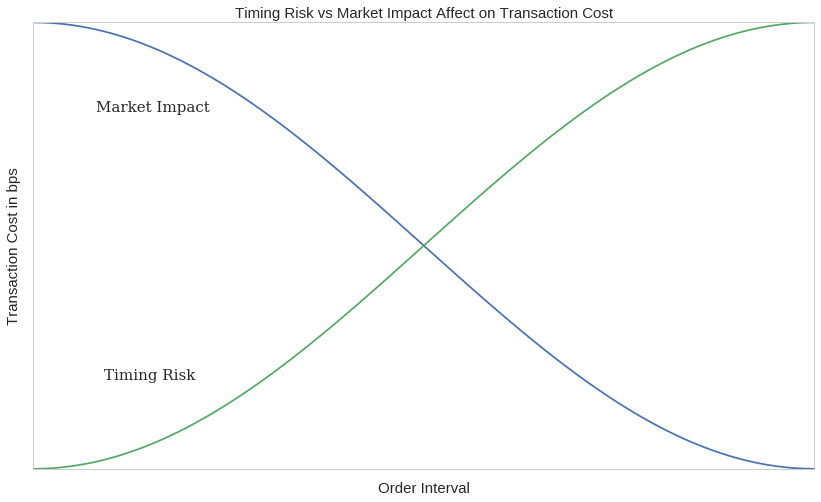

In [4]:
x = np.linspace(0,1,101)
risk = np.cos(x*np.pi)
impact = np.cos(x* np.pi+ np.pi)

fig,ax = plt.subplots(1)
# Make your plot, set your axes labels
ax.plot(x,risk)
ax.plot(x,impact)
ax.set_ylabel('Transaction Cost in bps', fontsize=15)
ax.set_xlabel('Order Interval', fontsize=15)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.grid(False)
ax.text(0.09, -0.6, 'Timing Risk', fontsize=15, fontname="serif")
ax.text(0.08, 0.6, 'Market Impact', fontsize=15, fontname="serif")
plt.title('Timing Risk vs Market Impact Affect on Transaction Cost', fontsize=15)
plt.show()

## **Liquidity**

Liquidity can be viewed through several lenses.  Within the context of execution management, we can think of it as activity, measured in shares and USD traded, as well as frequency and size of trades executed in the market.  "Good" liquidity is also achieved through a diverse number of market participants on both sides of the market.

Assess Liquidity by: 
* intraday volume curve 
* percent of day's volume 
* percent of average daily dollar volume in an interval
* cummulative intraday volume curve
* relative order size

In general, liquidity is highest as we approach the close, and second highest at the open. Mid day has the lowest liquidity. Liquidity should also be viewed relative to your order size and other securities in the same sector and class. 

Time: 0.31 seconds.


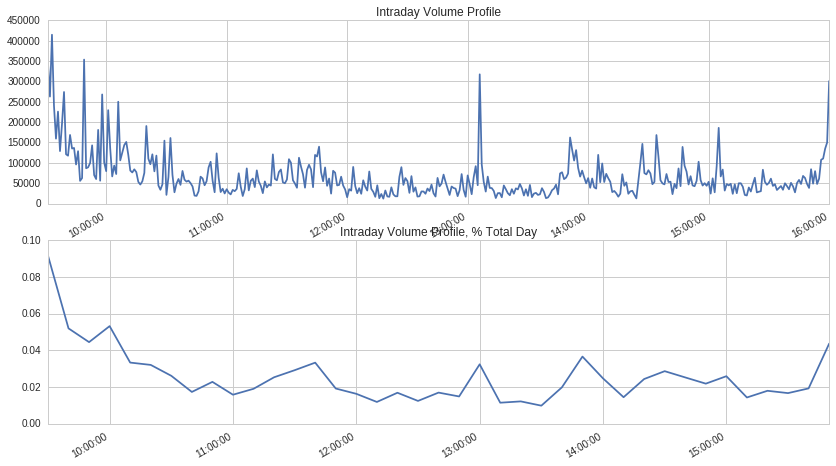

In [5]:
tickers = symbols(['FB']) # Facebook ticker
num_stocks = len(tickers)

# %%timeit -n1 -r1 magic is not allowed in Q
start = time.time()
data = get_pricing(tickers,
                   fields='volume',
                   frequency='minute',
                   start_date='2016-1-1',
                   end_date='2016-7-1')
end = time.time()
print "Time: %0.2f seconds." % (end - start)
data = data.tz_convert('US/Eastern') # Q data comes in as UTC

dat = data[symbols('FB')]
plt.subplot(211)
dat['2016-04-14'].plot(title='Intraday Volume Profile') # intraday volume profile plot 
plt.subplot(212)
(dat['2016-04-14'].resample('10t', closed='right').sum()/\
     dat['2016-04-14'].sum()).plot(); # percent volume plot
plt.title('Intraday Volume Profile, % Total Day');

In [6]:
df = pd.DataFrame(dat) # Facebook minutely volume data

df.columns = ['interval_vlm'] 

df_daysum = df.resample('d').sum() # take sum of each day 
df_daysum.columns = ['day_vlm']
df_daysum['day'] = df_daysum.index.date # add date index as column

df['min_of_day']=(df.index.hour-9)*60 + (df.index.minute-30) # calculate minutes from open
df['time']=df.index.time # add time index as column

conversion = {'interval_vlm':'sum', 'min_of_day':'last', 'time':'last'}
df = df.resample('10t', closed='right').apply(conversion) # apply conversions to columns at 10 min intervals
df['day'] = df.index.date

df = df.merge(df_daysum, how='left', on='day') # merge df and df_daysum dataframes
df['interval_pct'] = df['interval_vlm'] / df['day_vlm'] # calculate percent of days volume for each row
df.head()

,interval_vlm,time,min_of_day,day,day_vlm,interval_pct
0,2553931.0,09:40:00,10.0,2016-01-04,31872469.0,0.080130
1,2246748.0,09:50:00,20.0,2016-01-04,31872469.0,0.070492
2,1518230.0,10:00:00,30.0,2016-01-04,31872469.0,0.047635
3,1599570.0,10:10:00,40.0,2016-01-04,31872469.0,0.050187
4,1909115.0,10:20:00,50.0,2016-01-04,31872469.0,0.059899


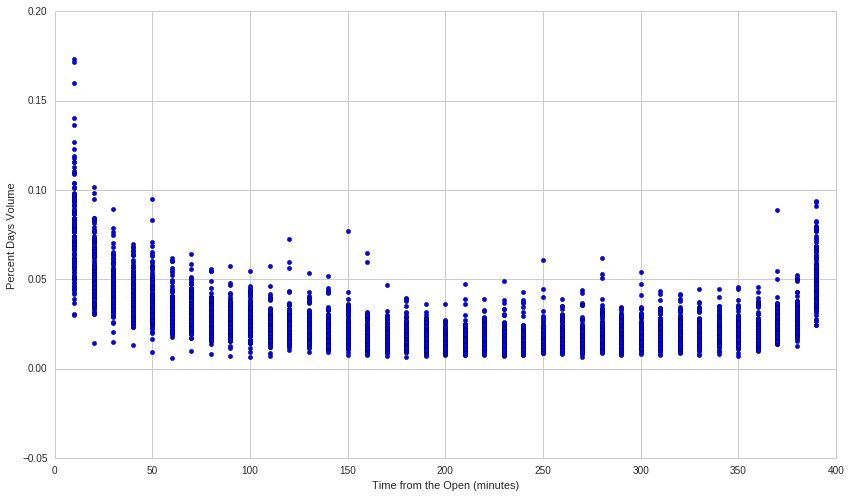

In [7]:
plt.scatter(df.min_of_day, df.interval_pct)
plt.xlim(0,400)
plt.xlabel('Time from the Open (minutes)')
plt.ylabel('Percent Days Volume')

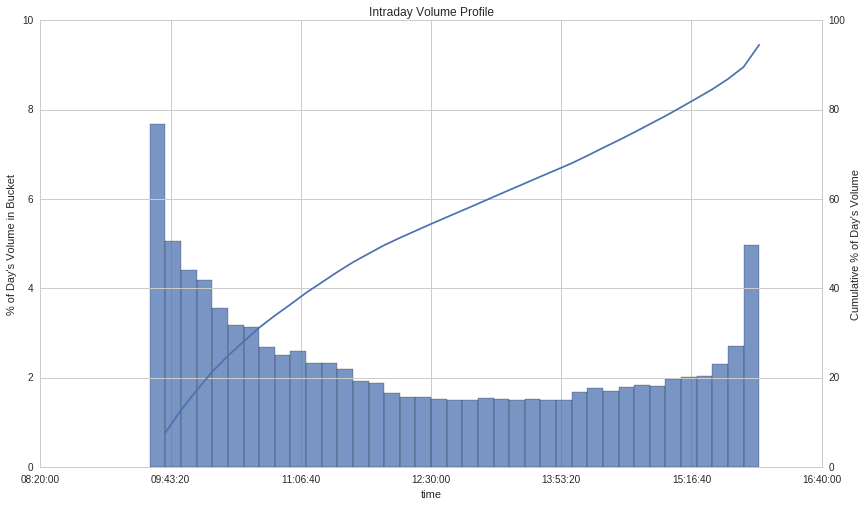

In [8]:
grouped = df.groupby(df.min_of_day)
grouped = df.groupby(df.time) # group by 10 minute interval times
m = grouped.median()  # get median values of groupby
x = m.index
y = m['interval_pct']

fig, ax1 = plt.subplots();
ax1.bar(x, 100*y, -60*10 ,alpha=0.75); # plot percent daily volume grouped by 10 minute interval times
ax1.set_ylim(0,10);
ax2 = ax1.twinx();
ax2.plot(x,(100*y).cumsum()); # plot cummulative distribution of median daily volume
ax2.set_ylim(0,100);
plt.title('Intraday Volume Profile');
ax1.set_ylabel('% of Day\'s Volume in Bucket');
ax2.set_ylabel('Cumulative % of Day\'s Volume');


## Relative Order Size

As we increase relative order size at a specified participation rate, the time to complete the order increases. Let's assume we execute an order using VWAP, a scheduling strategy, which executes orders over a pre-specified time window, according to the projections of volume distribution throughout that time window: At 3% participation rate for VWAP execution, we require the entire day to trade if our order represents 3% of average daily volume.

If we expect our algo to have high relative order sizes then we may want to switch to liquidity management execution strategy when trading to ensure order completion by the end of the day. Liquidity management execution strategies have specific constraints for the urgency of execution, choice of execution venues and spread capture with the objective of order completion. Going back to our risk curves, we expect higher transaction costs the longer we trade. Therefore, the higher percent ADV of an order the more expensive to trade. 

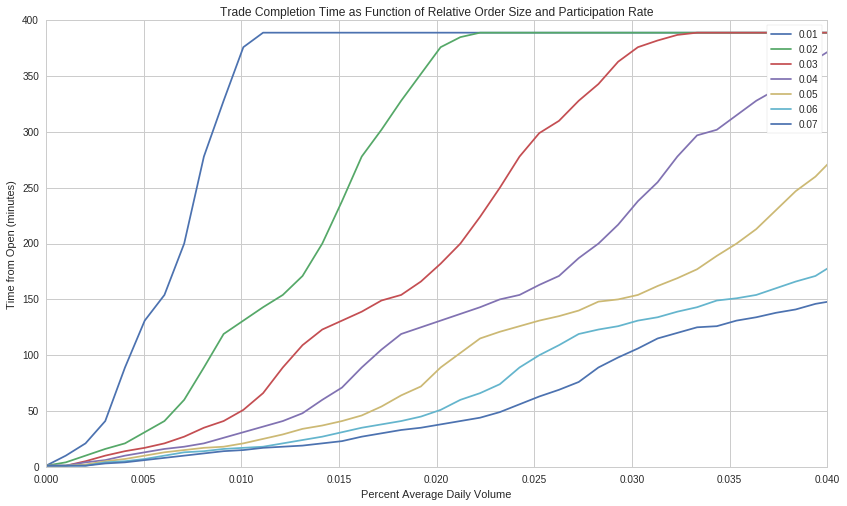

In [9]:

dat = get_pricing(symbols(['FB']), fields='volume', frequency='minute', start_date='2016-1-1', end_date='2018-1-2')
dat = dat.tz_convert('US/Eastern') # Q data comes in as UTC


def relative_order_size(participation_rate, pct_ADV):
    fill_start = dat['2017-10-02'].index[0] # start order at 9:31
    ADV20 = int(dat.resample("1d").sum()[-20:].mean()) # calculate 20 day ADV
    order_size = int(pct_ADV * ADV20)
    #print 'order size:', order_size, 'daily volume:', dat['2016-07-01'].sum()/(1.0*10**6), 'M shares'
    try :
        ftime = dat['2017-10-02'][(order_size * 1.0 / participation_rate)<=dat['2017-10-02'].cumsum().values].index[0]
    except: 
        ftime = dat['2017-10-02'].index[-1] # set fill time to 4p 
    fill_time = max(1,int((ftime - fill_start).total_seconds()/60.0))
    #print 'order fill time' ,fill_time,  'minutes'
    return fill_time

def create_plots(participation_rate, ax):
    df_pr = pd.DataFrame(data=np.linspace(0.0,0.1,100), columns = ['adv'] ) # create dataframe with intervals of ADV
    df_pr['pr'] = participation_rate # add participation rate column

    df_pr['fill_time'] = df_pr.apply(lambda row: relative_order_size(row['pr'],row['adv']), axis = 1) # get fill time

    ax.plot(df_pr['adv'],df_pr['fill_time'], label=participation_rate) # generate plot line with ADV and fill time

fig, ax = plt.subplots() 
for i in [0.01,0.02,0.03,0.04,0.05,0.06,0.07]: # for participation rate values
    create_plots(i,ax) # generate plot line
    
plt.ylabel('Time from Open (minutes)')
plt.xlabel('Percent Average Daily Volume')
plt.title('Trade Completion Time as Function of Relative Order Size and Participation Rate')
plt.xlim(0.,0.04)
ax.legend()



## Volatility

Volatilty is a statistical measure of dispersion of returns for a security. Calculated as the standard deviation of returns. The volatility of any given stock typically peaks at the open and therafter decreases until mid-day.The higher the volatility the more uncertainty in the returns. This uncertainty is an artifact of larger bid-ask spreads during the price discovery process at the start of the trading day. In contrast to liquidity, where we would prefer to trade at the open to take advantage of high volumes, to take advantage of low volatility we would trade at the close.

We use two methods to calculate volatility for demonstration purposes, OHLC and, the most common, close-to-close. OHLC uses the Garman-Klass Yang-Zhang volatilty estimate that employs open, high, low, and close data. 

OHLC VOLATILITY ESTIMATION METHOD 

$$\sigma^2 = \frac{Z}{n} \sum \left[\left(\ln \frac{O_i}{C_{i-1}} \right)^2  +  \frac{1}{2} \left( \ln \frac{H_i}{L_i} \right)^2 - (2 \ln 2 -1) \left( \ln \frac{C_i}{O_i} \right)^2 \right]$$



CLOSE TO CLOSE HISTORICAL VOLATILITY ESTIMATION METHOD

Volatility is calculated as the annualised standard deviation of log returns as detailed in the equation below.

$$ Log \thinspace return = x_1 = \ln (\frac{c_i + d_i}{c_i-1} ) $$
 where d_i  = ordinary(not adjusted) dividend and ci is close price
 $$ Volatilty =  \sigma_x \sqrt{ \frac{1}{N} \sum_{i=1}^{N} (x_i - \bar{x})^2 }$$

See end of notebook for references

In [10]:
tickers = symbols(['FB'])
start = time.time()
data = get_pricing(tickers, frequency='minute', start_date='2016-1-1', end_date='2016-7-1')
end = time.time()
print "Time: %0.2f seconds." % (end - start)

data.items
data.describe
data['price']
df = data.to_frame().unstack()
df.columns = df.columns.droplevel(1) # drop the ticker
df.index.name = None 
df = df.tz_convert('US/Eastern') # Q data comes in as UTC, convert to EST
df.head()


Time: 0.15 seconds.


,open_price,high,low,close_price,volume,price
2016-01-04 09:31:00-05:00,101.950,102.07,101.72,101.830,804756.0,101.830
2016-01-04 09:32:00-05:00,101.810,101.94,101.60,101.864,231895.0,101.864
2016-01-04 09:33:00-05:00,101.865,102.24,101.84,102.160,222334.0,102.160
2016-01-04 09:34:00-05:00,102.160,102.23,101.96,102.180,161446.0,102.180
2016-01-04 09:35:00-05:00,102.160,102.19,101.94,101.960,210727.0,101.960


In [11]:
def gkyz_var(open, high, low, close, close_tm1): # Garman Klass Yang Zhang extension OHLC volatility estimate
    return np.log(open/close_tm1)**2 + 0.5*(np.log(high/low)**2) \
        - (2*np.log(2)-1)*(np.log(close/open)**2)
    
def historical_vol(close_ret, mean_ret): # close to close volatility estimate
    return np.sqrt(np.sum((close_ret-mean_ret)**2)/390)

In [12]:
df['min_of_day'] = (df.index.hour-9)*60 + (df.index.minute-30) # calculate minute from the open
df['time'] = df.index.time # add column time index
df['day'] = df.index.date # add column date index
df.head()

,open_price,high,low,close_price,volume,price,min_of_day,time,day
2016-01-04 09:31:00-05:00,101.950,102.07,101.72,101.830,804756.0,101.830,1,09:31:00,2016-01-04
2016-01-04 09:32:00-05:00,101.810,101.94,101.60,101.864,231895.0,101.864,2,09:32:00,2016-01-04
2016-01-04 09:33:00-05:00,101.865,102.24,101.84,102.160,222334.0,102.160,3,09:33:00,2016-01-04
2016-01-04 09:34:00-05:00,102.160,102.23,101.96,102.180,161446.0,102.180,4,09:34:00,2016-01-04
2016-01-04 09:35:00-05:00,102.160,102.19,101.94,101.960,210727.0,101.960,5,09:35:00,2016-01-04


In [13]:
df['close_tm1'] = df.groupby('day')['close_price'].shift(1)  # shift close value down one row
df.close_tm1 = df.close_tm1.fillna(df.open_price)
df['min_close_ret'] = np.log( df['close_price'] /df['close_tm1']) # log of close to close
close_returns = df.groupby('day')['min_close_ret'].mean() # daily mean of log of close to close
new_df = df.merge(pd.DataFrame(close_returns), left_on ='day', right_index = True)
# handle when index goes from 16:00 to 9:31:

new_df['variance'] = new_df.apply(
    lambda row: historical_vol(row.min_close_ret_x, row.min_close_ret_y),
    axis=1)
#df['variance'] = df.apply(
#    lambda row: gkyz_var(row.open_price, row.high, row.low,
#                         row.close_price, row.close_tm1),
#    axis=1)

new_df.head()


,open_price,high,low,close_price,volume,price,min_of_day,time,day,close_tm1,min_close_ret_x,min_close_ret_y,variance
2016-01-04 09:31:00-05:00,101.950,102.07,101.72,101.830,804756.0,101.830,1,09:31:00,2016-01-04,101.950,-0.001178,0.000006,0.000060
2016-01-04 09:32:00-05:00,101.810,101.94,101.60,101.864,231895.0,101.864,2,09:32:00,2016-01-04,101.830,0.000334,0.000006,0.000017
2016-01-04 09:33:00-05:00,101.865,102.24,101.84,102.160,222334.0,102.160,3,09:33:00,2016-01-04,101.864,0.002902,0.000006,0.000147
2016-01-04 09:34:00-05:00,102.160,102.23,101.96,102.180,161446.0,102.180,4,09:34:00,2016-01-04,102.160,0.000196,0.000006,0.000010
2016-01-04 09:35:00-05:00,102.160,102.19,101.94,101.960,210727.0,101.960,5,09:35:00,2016-01-04,102.180,-0.002155,0.000006,0.000109


In [14]:
df_daysum = pd.DataFrame(new_df['variance'].resample('d').sum()) # get sum of intraday variances daily
df_daysum.columns = ['day_variance']
df_daysum['day'] = df_daysum.index.date
df_daysum.head()

,day_variance,day
2016-01-04 00:00:00-05:00,0.013261,2016-01-04
2016-01-05 00:00:00-05:00,0.011726,2016-01-05
2016-01-06 00:00:00-05:00,0.013465,2016-01-06
2016-01-07 00:00:00-05:00,0.019523,2016-01-07
2016-01-08 00:00:00-05:00,0.015441,2016-01-08


In [15]:

conversion = {'variance':'sum', 'min_of_day':'last', 'time':'last'}
df = new_df.resample('10t', closed='right').apply(conversion)
df['day'] = df.index.date
df['time'] = df.index.time
df.head()

,variance,time,min_of_day,day
2016-01-04 09:30:00-05:00,0.000691,09:30:00,10.0,2016-01-04
2016-01-04 09:40:00-05:00,0.000875,09:40:00,20.0,2016-01-04
2016-01-04 09:50:00-05:00,0.000740,09:50:00,30.0,2016-01-04
2016-01-04 10:00:00-05:00,0.000489,10:00:00,40.0,2016-01-04
2016-01-04 10:10:00-05:00,0.000654,10:10:00,50.0,2016-01-04


In [16]:
df = df.merge(df_daysum, how='left', on='day') # merge daily and intraday volatilty dataframes
df['interval_pct'] = df['variance'] / df['day_variance'] # calculate percent of days volatility for each row
df.head()

,variance,time,min_of_day,day,day_variance,interval_pct
0,0.000691,09:30:00,10.0,2016-01-04,0.013261,0.052138
1,0.000875,09:40:00,20.0,2016-01-04,0.013261,0.065999
2,0.000740,09:50:00,30.0,2016-01-04,0.013261,0.055801
3,0.000489,10:00:00,40.0,2016-01-04,0.013261,0.036899
4,0.000654,10:10:00,50.0,2016-01-04,0.013261,0.049305


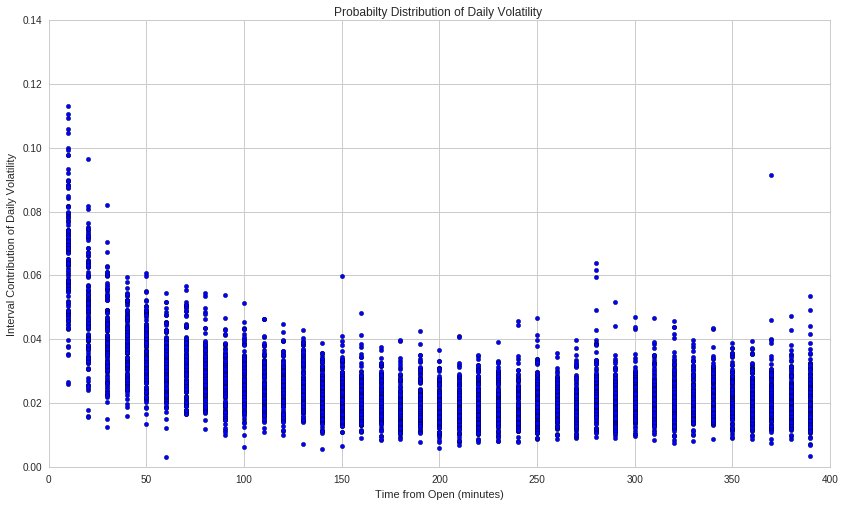

In [17]:
plt.scatter(df.min_of_day, df.interval_pct)
plt.xlim(0,400)
plt.ylim(0,)
plt.xlabel('Time from Open (minutes)')
plt.ylabel('Interval Contribution of Daily Volatility')
plt.title('Probabilty Distribution of Daily Volatility ')

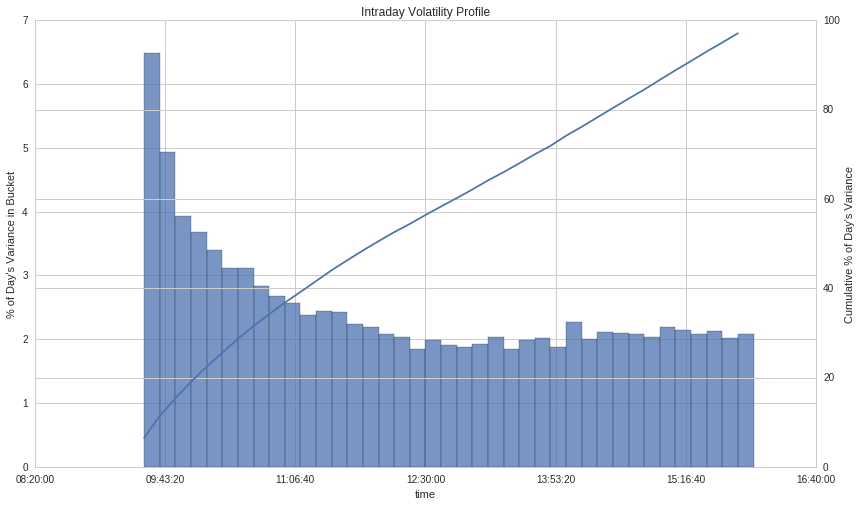

In [18]:
grouped = df.groupby(df.min_of_day)
grouped = df.groupby(df.time) # groupby time
m = grouped.median() # get median
x = m.index
y = m['interval_pct']

fig, ax1 = plt.subplots()
ax1.bar(x, 100*y, 60*10 ,alpha=0.75);# plot interval percent of median daily volatility 
ax2 = ax1.twinx()
ax2.plot(x, (100*y).cumsum()) # plot cummulative distribution of median daily volatility
ax2.set_ylim(0,100);
plt.title('Intraday Volatility Profile')
ax1.set_ylabel('% of Day\'s Variance in Bucket');
ax2.set_ylabel('Cumulative % of Day\'s Variance');
#cut off graph at 4pm

## Bid-Ask Spread


The following relationships between bid-ask spread and order attributes are seen in our live trading data:

* As **market cap ** increases we expect spreads to decrease.  Larger companies tend to exhibit lower bid-ask spreads.

* As **volatility ** increases we expect spreads to increase. Greater price uncertainty results in wider bid-ask spreads.

* As  **average daily dollar volume ** increases, we expect spreads to decrease. Liquidity tends to be inversely proportional to spreads, due to larger number of participants and more frequent updates to quotes.

* As  **price ** increases, we expect spreads to decrease (similar to market cap), although this relationship is not as strong.

* As  **time of day ** progresses we expect spreads to decrease. During early stages of a trading day, price discovery takes place. in contrast, at market close order completion is the priority of most participants and activity is led by liquidity management, rather than price discovery.  

The Trading Team developed a log-linear model fit to our live data that predicts the spread for a security with which we have the above listed attributes. 

In [19]:
def model_spread(time, vol, mcap = 1.67 * 10 ** 10, adv = 84.5, px = 91.0159):
    time_bins = np.array([0.0, 960.0, 2760.0, 5460.0, 21660.0]) #seconds from market open
    time_coefs = pd.Series([0.0, -0.289, -0.487, -0.685, -0.952])
    
    vol_bins = np.array([0.0, .1, .15, .2, .3, .4])
    vol_coefs = pd.Series([0.0, 0.251, 0.426, 0.542, 0.642, 0.812])
    
    mcap_bins = np.array([0.0, 2.0, 5.0, 10.0, 25.0, 50.0]) * 10 ** 9
    mcap_coefs = pd.Series([0.291, 0.305, 0.0, -0.161, -0.287, -0.499])
    
    adv_bins = np.array([0.0, 50.0, 100.0, 150.0, 250.0, 500.0]) * 10 ** 6
    adv_coefs = pd.Series([0.303, 0.0, -0.054, -0.109, -0.242, -0.454])
    
    px_bins = np.array([0.0, 28.0, 45.0, 62.0, 82.0, 132.0])
    px_coefs = pd.Series([-0.077, -0.187, -0.272, -0.186, 0.0, 0.380])
    
    return np.exp(1.736 +\
                  time_coefs[np.digitize(time, time_bins) - 1] +\
                  vol_coefs[np.digitize(vol, vol_bins) - 1] +\
                  mcap_coefs[np.digitize(mcap, mcap_bins) - 1] +\
                  adv_coefs[np.digitize(adv, adv_bins) - 1] +\
                  px_coefs[np.digitize(px, px_bins) - 1])




### Predict the spread for the following order : 
* Stock: DPS
* Qty:  425 shares
* Time of day : 9:41 am July 19, 2017, 600 seconds from open
* Market Cap : 1.67e10
* Volatility: 18.8%
* ADV : 929k shares  ; 84.5M dollars
* Avg Price : 91.0159

In [20]:
t = 10 * 60
vlty = 0.188
mcap = 1.67 * 10 ** 10
adv = 84.5 *10
price = 91.0159 
print model_spread(t, vlty, mcap, adv, price), 'bps'

10.0141590846 bps


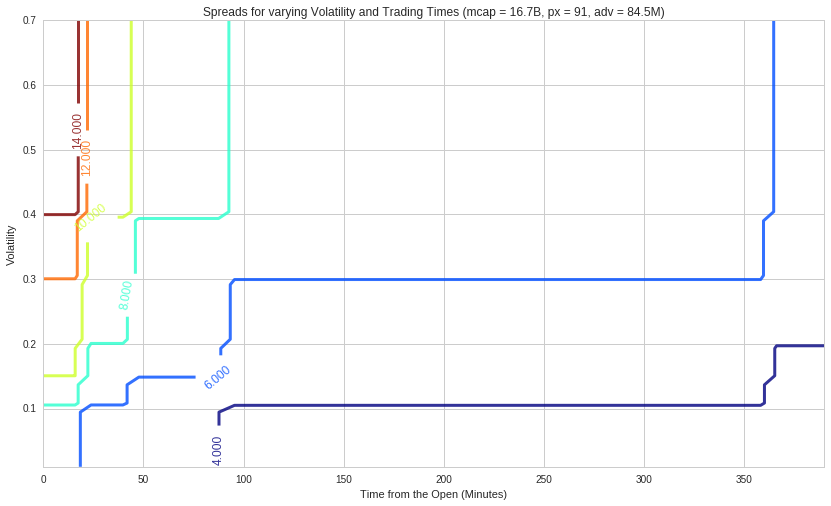

In [21]:
x = np.linspace(0,390*60) # seconds from open shape (50,)
y = np.linspace(.01,.7) # volatility shape(50,)
mcap = 1.67 * 10 ** 10
adv = 84.5
px = 91.0159


vlty_coefs = pd.Series([0.0, 0.251, 0.426, 0.542, 0.642, 0.812])
vlty_bins = np.array([0.0, .1, .15, .2, .3, .4])
time_bins = np.array([0.0, 960.0, 2760.0, 5460.0, 21660.0]) #seconds from market open
time_coefs = pd.Series([0.0, -0.289, -0.487, -0.685, -0.952])
mcap_bins = np.array([0.0, 2.0, 5.0, 10.0, 25.0, 50.0]) * 10 ** 9
mcap_coefs = pd.Series([0.291, 0.305, 0.0, -0.161, -0.287, -0.499])
adv_bins = np.array([0.0, 50.0, 100.0, 150.0, 250.0, 500.0]) * 10 ** 6
adv_coefs = pd.Series([0.303, 0.0, -0.054, -0.109, -0.242, -0.454])
px_bins = np.array([0.0, 28.0, 45.0, 62.0, 82.0, 132.0])
px_coefs = pd.Series([-0.077, -0.187, -0.272, -0.186, 0.0, 0.380])
# shape (1, 50)
time_contrib = np.take(time_coefs, np.digitize(x, time_bins) - 1).reshape((1, len(x)))
# shape (50, 1)
vlty_contrib = np.take(vlty_coefs, np.digitize(y, vlty_bins) - 1).reshape((len(y), 1))
# scalar
mcap_contrib = mcap_coefs[np.digitize((mcap,), mcap_bins)[0] - 1]
# scalar
adv_contrib = adv_coefs[np.digitize((adv,), adv_bins)[0] - 1]
# scalar
px_contrib = px_coefs[np.digitize((px,), px_bins)[0] - 1]

z_scalar_contrib = 1.736 + mcap_contrib + adv_contrib + px_contrib


Z = np.exp(z_scalar_contrib + time_contrib + vlty_contrib)

cmap=plt.get_cmap('jet')
X, Y = np.meshgrid(x,y)
CS = plt.contour(X/60,Y,Z, linewidths=3, cmap=cmap, alpha=0.8);
plt.clabel(CS)
plt.xlabel('Time from the Open (Minutes)')
plt.ylabel('Volatility')
plt.title('Spreads for varying Volatility and Trading Times (mcap = 16.7B, px = 91, adv = 84.5M)')
plt.show()

## **Quantifying Market Impact**

Theoritical Market Impact models attempt to estimate transaction costs of trading by utilizing order attributes. There are many published market impact models. Here are some examples: 

1. Quantopian Volume Slippage Model 
2. Almgren et al 2005
3. Kissell et al. 2004
4. J.P. Morgan Model 2010


The models have a few commonalities such as the inclusion of relative order size, volatility as well as custom parameters calculated from observed trades.There are also notable differences in the models such as (1)  JPM explictly calls out spread impact, (2) Almgren considers fraction of outstanding shares traded daily, (3) Q Slipplage Model does not consider volatility , and (4) Kissel explicit parameter to proportion temporary and permenant impact, to name a few.

The academic models have notions of temporary and permanant impact. **Temporary Impact** captures the impact on transaction costs due to urgency or aggressiveness of the trade. While **Permenant Impact** estimates with respect to information or short term alpha in a trade.

### Almgren et al. model (2005)
 
This model assumes the initial order, X, is completed at a uniform rate of trading over a volume time
interval T. That is, the trade rate in volume units is v = X/T, and is held
constant until the trade is completed. Constant rate in these units is
equivalent to VWAP execution during the time of execution. 


Almgren et al. model these two terms as



$$\text{tcost} = 0.5 \overbrace{\gamma \sigma  \frac{X}{V}\left(\frac{\Theta}{V}\right)^{1/4}}^{\text{permanent}} + \overbrace{\eta \sigma \left| \frac{X}{VT} \right|^{3/5}}^{\text{temporary}} $$


where $\gamma$ and $\eta$ are the "universal coefficients of market impact" and estimated by the authors using a large sample of institutional trades; $\sigma$ is the daily volatility of the stock; $\Theta$ is the total shares outstanding of the stock; $X$ is the number of shares you would like to trade (unsigned); $T$ is the time width in % of trading time over which you slice the trade; and $V$ is the average daily volume ("ADV") in shares of the stock. The interpretation of $\frac{\Theta}{V}$ is the inverse of daily "turnover", the fraction of the company's value traded each day.

For reference, FB has 2.3B shares outstanding, its average daily volume over 20 days is 18.8M therefore its inverse turnover is approximately 122, put another way, it trades less than 4% of outstanding shares daily.



### Potential Limitations

Note that the Almgren et al (2005) and Kissell, Glantz and Malamut (2004) papers were released prior to the adoption and phased implementation of [__Reg NMS__](https://www.sec.gov/rules/final/34-51808.pdf), prior to the "quant meltdown" of August 2007, prior to the financial crisis hitting markets in Q4 2008, and other numerous developments in market microstructure. 


In [22]:
def perm_impact(pct_adv, annual_vol_pct = 0.25, inv_turnover = 200):
    gamma = 0.314
    return 10000 * gamma * (annual_vol_pct / 16) * pct_adv * (inv_turnover)**0.25

def temp_impact(pct_adv, minutes, annual_vol_pct = 0.25, minutes_in_day = 60*6.5):
    eta = 0.142
    day_frac = minutes / minutes_in_day
    return 10000 * eta * (annual_vol_pct / 16) * abs(pct_adv/day_frac)**0.6

def tc_bps(pct_adv, minutes, annual_vol_pct = 0.25, inv_turnover = 200, minutes_in_day = 60*6.5):
    perm = perm_impact(pct_adv, annual_vol_pct=annual_vol_pct, inv_turnover=inv_turnover)
    temp = temp_impact(pct_adv, minutes, annual_vol_pct=annual_vol_pct, minutes_in_day=minutes_in_day)
    return 0.5 * perm + temp


So if we are trading 10% of ADV of a stock with a daily vol of 1.57% and we plan to do this over half the day, we would expect 8bps of TC (which is the Almgren estimate of temporary impact cost in this scenario). From the paper, this is a sliver of the output at various trading speeds:

  Variable      |      IBM
  ------------- | -------------
  Inverse turnover ($\Theta/V$) | 263
  Daily vol ($\sigma$)  | 1.57%
  Trade % ADV (X/V) | 10%
  
  Item | Fast | Medium | Slow
  -----|------|--------|-------
  Permanent Impact (bps) | 20 | 20 | 20
  Trade duration (day fraction %) | 10% | 20% | 50%
  Temporary Impact (bps) | 22 | 15 | 8
  Total Impact (bps) | 32 | 25 | 18
  

In [23]:
print 'Cost to trade Fast (First 40 mins):', round(tc_bps(pct_adv=0.1, annual_vol_pct=16*0.0157, inv_turnover=263, minutes=0.1*60*6.5),2), 'bps'
print 'Cost to trade Medium (First 90 mins):', round(tc_bps(pct_adv=0.1, annual_vol_pct=16*0.0157, inv_turnover=263, minutes=0.2*60*6.5),2), 'bps' 
print 'Cost to trade Slow by Noon:', round(tc_bps(pct_adv=0.1, annual_vol_pct=16*0.0157, inv_turnover=263, minutes=0.5*60*6.5),2), 'bps'


Cost to trade Fast (First 40 mins): 32.22 bps
Cost to trade Medium (First 90 mins): 24.63 bps
Cost to trade Slow by Noon: 18.41 bps


Trading 0.50% of ADV of a stock with a daily vol of 1.57% and we plan to do this over 30 minutes...

In [24]:
print round(tc_bps(pct_adv=0.005, minutes=30, annual_vol_pct=16*0.0157),2)

4.79


Let's say we wanted to trade \$2M notional of Facebook, and we are going to send the trade to an execution algo (e.g., VWAP) to be sliced over 15 minutes.

In [25]:
trade_notional = 2000000 # 2M notional
stock_price = 110.89 # dollars per share
shares_to_trade = trade_notional/stock_price
stock_adv_shares = 30e6 # 30 M
stock_shares_outstanding = 275e9/110.89

expected_tc = tc_bps(shares_to_trade/stock_adv_shares, minutes=15, annual_vol_pct=0.22)
print "Expected tc in bps: %0.2f" % expected_tc
print "Expected tc in $ per share: %0.2f" % (expected_tc*stock_price / 10000)

Expected tc in bps: 1.66
Expected tc in $ per share: 0.02


And to motivate some intuition, at the total expected cost varies as a function of how much % ADV we want to trade in 30 minutes.

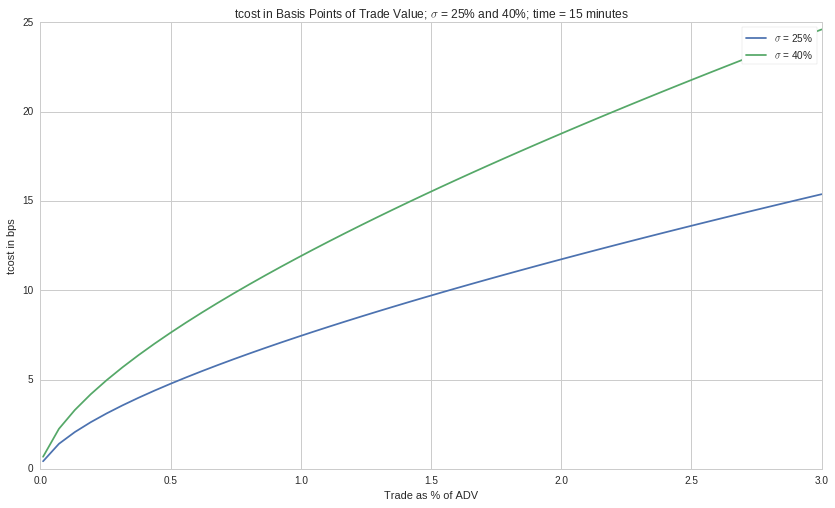

In [26]:
x = np.linspace(0.0001,0.03)
plt.plot(x*100,tc_bps(x,30,0.25), label="$\sigma$ = 25%");
plt.plot(x*100,tc_bps(x,30,0.40), label="$\sigma$ = 40%");
plt.ylabel('tcost in bps')
plt.xlabel('Trade as % of ADV')
plt.title('tcost in Basis Points of Trade Value; $\sigma$ = 25% and 40%; time = 15 minutes');
plt.legend();

And let's look a tcost as a function of trading time and % ADV.

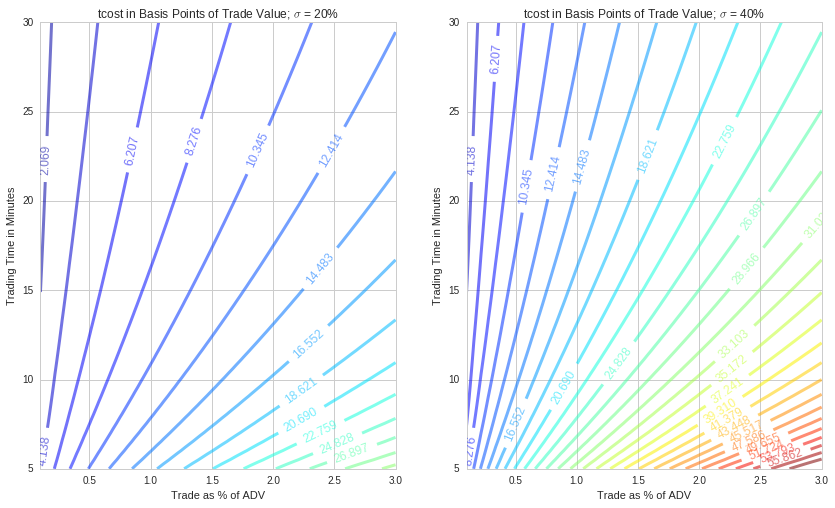

In [27]:
x = np.linspace(0.001,0.03)
y = np.linspace(5,30)
X, Y = np.meshgrid(x,y)
Z = tc_bps(X,Y,0.20)
levels = np.linspace(0.0, 60, 30)
cmap=plt.get_cmap('Reds')
cmap=plt.get_cmap('hot')
cmap=plt.get_cmap('jet')

plt.subplot(1,2,1);
CS = plt.contour(X*100, Y, Z, levels, linewidths=3, cmap=cmap, alpha=0.55);
plt.clabel(CS);
plt.ylabel('Trading Time in Minutes');
plt.xlabel('Trade as % of ADV');
plt.title('tcost in Basis Points of Trade Value; $\sigma$ = 20%');

plt.subplot(1,2,2);
Z = tc_bps(X,Y,0.40)
CS = plt.contour(X*100, Y, Z, levels, linewidths=3, cmap=cmap, alpha=0.55);
plt.clabel(CS);
plt.ylabel('Trading Time in Minutes');
plt.xlabel('Trade as % of ADV');
plt.title('tcost in Basis Points of Trade Value; $\sigma$ = 40%');

Alternatively, we might want to get some intuition as to if we wanted to limit our cost, how does the trading time vary versus % of ADV.

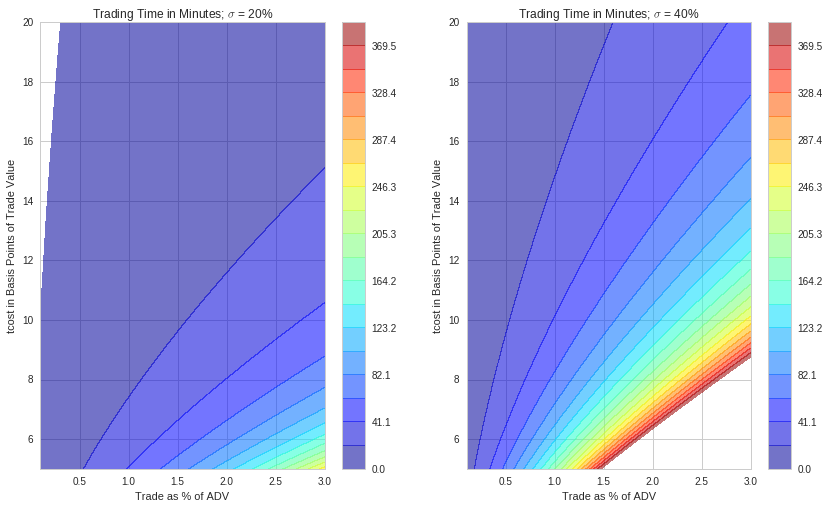

In [28]:
x = np.linspace(0.001,0.03) # % ADV
y = np.linspace(1,60*6.5)   # time to trade
X, Y = np.meshgrid(x, y)

levels = np.linspace(0.0, 390, 20)
cmap=plt.get_cmap('Reds')
cmap=plt.get_cmap('hot')
cmap=plt.get_cmap('jet')

plt.subplot(1,2,1);

Z = tc_bps(X,Y,0.20)
plt.contourf(X*100, Z, Y, levels, cmap=cmap, alpha=0.55);
plt.title('Trading Time in Minutes; $\sigma$ = 20%');
plt.xlabel('Trade as % of ADV');
plt.ylabel('tcost in Basis Points of Trade Value');
plt.ylim(5,20)
plt.colorbar();

plt.subplot(1,2,2);
Z = tc_bps(X,Y,0.40)
plt.contourf(X*100, Z, Y, levels, cmap=cmap, alpha=0.55);
plt.title('Trading Time in Minutes; $\sigma$ = 40%');
plt.xlabel('Trade as % of ADV');
plt.ylabel('tcost in Basis Points of Trade Value');
plt.ylim(5,20);
plt.colorbar();



### The Breakdown: Permanent and Temporary

For a typical stock, let's see how the tcost is broken down into permanent and temporary.

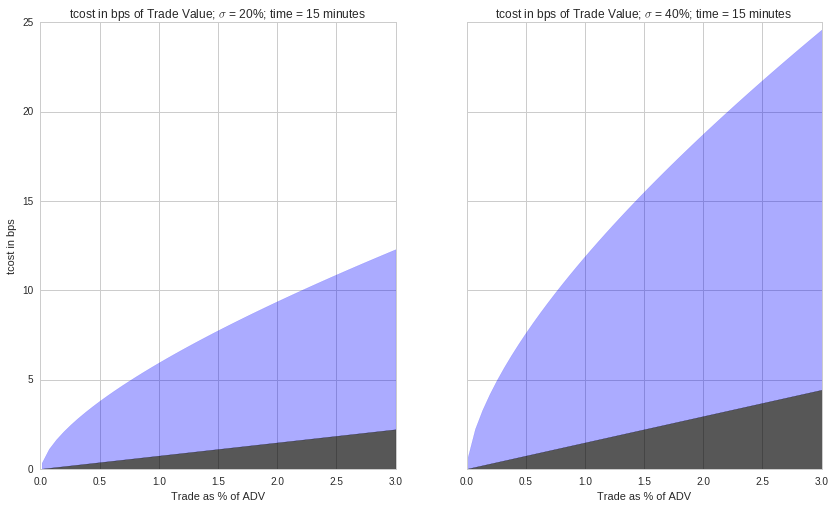

In [29]:
minutes = 30

x = np.linspace(0.0001,0.03)

f, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True)
f.subplots_adjust(hspace=0.15)
    
p = 0.5*perm_impact(x,0.20)
t = tc_bps(x,minutes,0.20)
ax1.fill_between(x*100, p, t, color='b', alpha=0.33);
ax1.fill_between(x*100, 0, p, color='k', alpha=0.66);
ax1.set_ylabel('tcost in bps')
ax1.set_xlabel('Trade as % of ADV')
ax1.set_title('tcost in bps of Trade Value; $\sigma$ = 20%; time = 15 minutes');

p = 0.5*perm_impact(x, 0.40)
t = tc_bps(x,minutes, 0.40)
ax2.fill_between(x*100, p, t, color='b', alpha=0.33);
ax2.fill_between(x*100, 0, p, color='k', alpha=0.66);

plt.xlabel('Trade as % of ADV')
plt.title('tcost in bps of Trade Value; $\sigma$ = 40%; time = 15 minutes');

### Kissell et al Model (2004)

This model assumes there is a theoretical instaenous impact cost $I^*$ incurred by the investor if all shares $Q$ were released to the market.

$$ MI_{bp} = b_1 I^* POV^{a_4} + (1-b_1)I^*$$


$$ I^*  = a_1 (\frac{Q}{ADV})^{a_2} \sigma^{a_3}$$

$$POV = \frac{Q}{Q+V}$$

* $I^*$ is instanteous impact
* $POV$ is percentage of volume trading rate
* $V$ is the expected volume in the interval of trading
* $b_1$ is the temporary impact parameter
* $ADV$ is 30 day average daily volume
* $Q$ is order size


  Parameter      |      Fitted Values
  ------------- | -------------
  $b_1$ | 0.80
  $a_1$  | 750
  $a_2$  | 0.50
  $a_3$  | 0.75
  $a_4$  | 0.50

In [30]:
def kissell(adv, annual_vol, interval_vol, order_size):
    b1, a1, a2, a3, a4 = 0.9, 750., 0.2, 0.9, 0.5
    i_star = a1 * ((order_size/adv)**a2) * annual_vol**a3
    PoV = order_size/(order_size + adv)
    return b1 * i_star * PoV**a4 + (1 - b1) * i_star

In [31]:
print kissell(adv = 5*10**6, annual_vol = 0.2, interval_vol = adv * 0.06, order_size = 0.01 * adv ), 'bps'

0.781932862915 bps


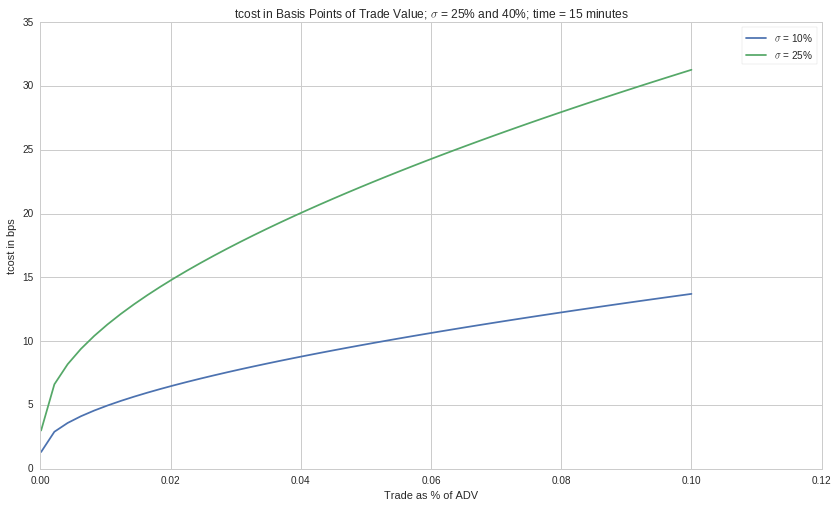

In [32]:
x = np.linspace(0.0001,0.1)
plt.plot(x,kissell(5*10**6,0.1, 2000*10**3, x*2000*10**3), label="$\sigma$ = 10%");
plt.plot(x,kissell(5*10**6,0.25, 2000*10**3, x*2000*10**3), label="$\sigma$ = 25%");
#plt.plot(x,kissell(5*10**6,0.40, 2000*10**3, x*2000*10**3), label="$\sigma$ = 40%");
plt.ylabel('tcost in bps')
plt.xlabel('Trade as % of ADV')
plt.title('tcost in Basis Points of Trade Value; $\sigma$ = 25% and 40%; time = 15 minutes');
plt.legend();

## The J.P. Morgan Market Impact Model


$$MI(bps) = I \times \omega \times \frac{2 \times PoV}{1 + PoV} + (1-\omega) \times I + S_c$$
Where

$$I = \alpha \times PoV^\beta \times Volatility^\gamma$$

* $\omega$ is the fraction of temporary impact (liquidity cost)
* $\alpha$ is a scaling parameter
* $PoV$ is relative order size as fraction of average daily volume
* $S_c$ is the spread ( basis point difference between the bid and ask )


For US equities, the fitted parameters as of June 2016 are

  Parameter | Fitted Value
  ------|-----
  b ($\omega$) | 0.931
  a1 ($\alpha$)| 168.5
  a2 ($\beta$) | 0.1064
  a3 ($\gamma$) | 0.9233


In [33]:
from __future__ import division

def jpm_mi(size_shrs, adv, day_frac=1.0, spd=5,
           spd_frac=0.5, ann_vol=0.25, omega=0.92,
           alpha=350, beta=0.370, gamma=1.05):

    PoV = (size_shrs/(adv*day_frac))
    I = alpha*(PoV**beta)*(ann_vol**gamma)
    MI = I*omega*(2*PoV)/(1+PoV) + (1-omega)*I + spd*spd_frac
    return MI

def jpm_mi_pct(pct_adv, **kwargs):
    return jpm_mi(pct_adv, 1.0, **kwargs)


Let's assume the following order:
* Buy 100,000 XYZ, trading at 10% of the volume
* XYZ's ADV = 1,000,000 shares
* XYZ Annualized Volatility = 25%
* XYZ's Average Spread = 5 bps

In [34]:
spy_adv = 85603411.55
print round(jpm_mi(size_shrs = 10000, adv = 1e6),2), 'bps' # 1% pct ADV order
print round(jpm_mi(size_shrs = 0.05*spy_adv, adv = spy_adv, spd = 5, day_frac = 1.0),2), 'bps' # 5% pct ADV of SPY order

3.96 bps
7.02 bps


##  Quantopian Volume Share Slippage

The [Q `VolumeShareSlippage` model](https://www.quantopian.com/help#ide-slippage)  expressed in the style of the equation below

$$\text{tcost} = 0.1 \left| \frac{X}{VT} \right|^2 $$

where $X$ is the number of shares you would like to trade; $T$ is the time width of the bar in % of a day; $V$ is the ADV of the stock.

For more information on the Quantopian Slippage Model see : https://www.quantopian.com/help#ide-slippage

In [35]:
def tc_Q_vss_bps(pct_adv, minutes=1.0, minutes_in_day=60*6.5):
    day_frac = minutes / minutes_in_day
    tc_pct = 0.1 * abs(pct_adv/day_frac)**2
    return tc_pct*10000

To reproduce the given Q examples, we trade over a bar

In [36]:
print tc_Q_vss_bps(pct_adv=0.1/390, minutes=1)
print tc_Q_vss_bps(pct_adv=0.25/390, minutes=1)

10.0
62.5


As this model is convex, it gives very high estimates for large trades.

In [37]:
print tc_Q_vss_bps(pct_adv=0.1, minutes=0.1*60*6.5)
print tc_Q_vss_bps(pct_adv=0.1, minutes=0.2*60*6.5)
print tc_Q_vss_bps(pct_adv=0.1, minutes=0.5*60*6.5)

1000.0
250.0
40.0


Though for small trades, the results are comparable.

In [38]:
print tc_bps(pct_adv=0.005, minutes=30, annual_vol_pct=0.2)
print tc_Q_vss_bps(pct_adv=0.005, minutes=30)

3.81208329371
4.225


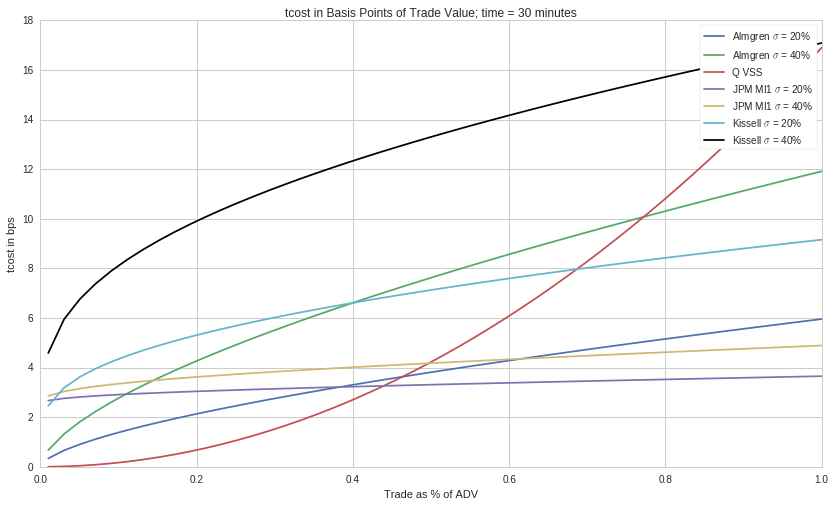

In [39]:
x = np.linspace(0.0001, 0.01)
plt.plot(x*100,tc_bps(x, 30, 0.20), label="Almgren $\sigma$ = 20%");
plt.plot(x*100,tc_bps(x, 30, 0.40), label="Almgren $\sigma$ = 40%");
plt.plot(x*100,tc_Q_vss_bps(x, minutes=30),label="Q VSS");
plt.plot(x*100,jpm_mi_pct(x, ann_vol=0.2), label="JPM MI1 $\sigma$ = 20%");
plt.plot(x*100,jpm_mi_pct(x, ann_vol=0.4), label="JPM MI1 $\sigma$ = 40%");
plt.plot(x*100,kissell(5*10**6,0.20, 2000*10**3, x*2000*10**3), label="Kissell $\sigma$ = 20%");
plt.plot(x*100,kissell(5*10**6,0.40, 2000*10**3, x*2000*10**3), label="Kissell $\sigma$ = 40%", color='black');

plt.ylabel('tcost in bps')
plt.xlabel('Trade as % of ADV')
plt.title('tcost in Basis Points of Trade Value; time = 30 minutes');
plt.legend();

## Conclusions

### The following order atttributes leads to higher market impact:
* Higher relative order size 
* Trading illquid names
* Trading names with lower daily turnover (in terms of shares outstanding)
* Shorter trade duration
* Higher volatility names 
* More urgency or higher POV
* Short term alpha
* Trading earlier in the day
* Trading names with wider spreads
* Trading lower ADV names or on days when market volume is down


## References:

* Almgren, R., Thum, C., Hauptmann, E., & Li, H. (2005). Direct estimation of equity market impact. Risk, 18(7), 5862.

* Bennett, C. and Gil, M.A. (2012, Februrary)  Measuring Historic Volatility, Santander Equity Derivatives Europe Retreived from: (http://www.todaysgroep.nl/media/236846/measuring_historic_volatility.pdf)

* Garman, M. B., & Klass, M. J. (1980). On the estimation of security price volatilities from historical data. Journal of business, 67-78.

* Kissell, R., Glantz, M., & Malamut, R. (2004). A practical framework for estimating transaction costs and developing optimal trading strategies to achieve best execution. Finance Research Letters, 1(1), 35-46.

* Quantopian Slippage Model see : https://www.quantopian.com/help#ide-slippage


*The material on this website is provided for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation or endorsement for any security or strategy, nor does it constitute an offer to provide investment advisory services by Quantopian. In addition, the material offers no opinion with respect to the suitability of any security or specific investment. No information contained herein should be regarded as a suggestion to engage in or refrain from any investment-related course of action as none of Quantopian nor any of its affiliates is undertaking to provide investment advice, act as an adviser to any plan or entity subject to the Employee Retirement Income Security Act of 1974, as amended, individual retirement account or individual retirement annuity, or give advice in a fiduciary capacity with respect to the materials presented herein. If you are an individual retirement or other investor, contact your financial advisor or other fiduciary unrelated to Quantopian about whether any given investment idea, strategy, product or service described herein may be appropriate for your circumstances. All investments involve risk, including loss of principal. Quantopian makes no guarantees as to the accuracy or completeness of the views expressed in the website. The views are subject to change, and may have become unreliable for various reasons, including changes in market conditions or economic circumstances.*